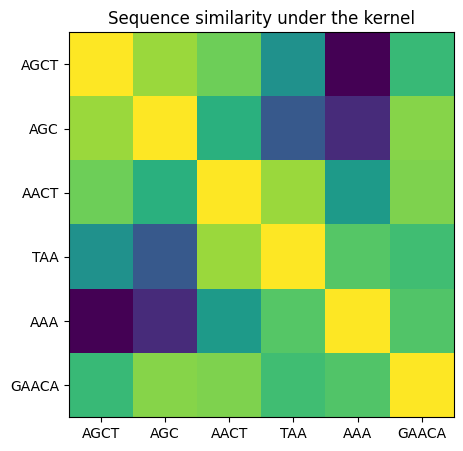

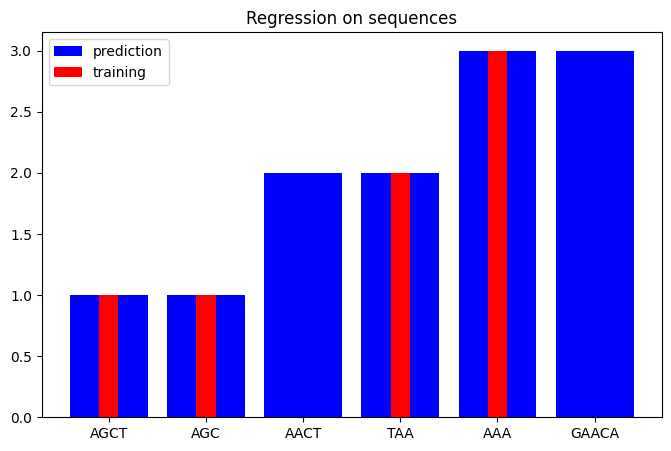

c:\Users\wrksy\miniconda3\envs\projects\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter baseline_similarity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


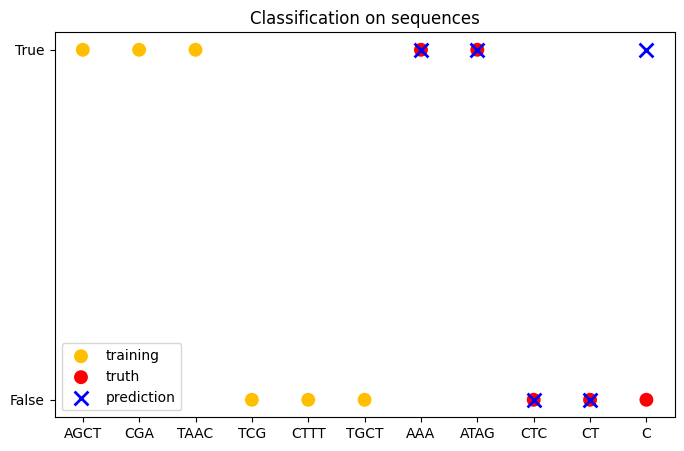

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import GenericKernelMixin, Hyperparameter, Kernel

# Define custom sequence kernel
class SequenceKernel(GenericKernelMixin, Kernel):
    def __init__(self, baseline_similarity=0.5, baseline_similarity_bounds=(1e-5, 1)):
        self.baseline_similarity = baseline_similarity
        self.baseline_similarity_bounds = baseline_similarity_bounds

    @property
    def hyperparameter_baseline_similarity(self):
        return Hyperparameter(
            "baseline_similarity", "numeric", self.baseline_similarity_bounds
        )

    def _f(self, s1, s2):
        return sum([1.0 if c1 == c2 else self.baseline_similarity for c1 in s1 for c2 in s2])

    def _g(self, s1, s2):
        return sum([0.0 if c1 == c2 else 1.0 for c1 in s1 for c2 in s2])

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        if eval_gradient:
            return (
                np.array([[self._f(x, y) for y in Y] for x in X]),
                np.array([[[self._g(x, y)] for y in Y] for x in X]),
            )
        else:
            return np.array([[self._f(x, y) for y in Y] for x in X])

    def diag(self, X):
        return np.array([self._f(x, x) for x in X])

    def is_stationary(self):
        return False

    def clone_with_theta(self, theta):
        cloned = clone(self)
        cloned.theta = theta
        return cloned

kernel = SequenceKernel()

# Sequence similarity matrix under the kernel
X = np.array(["AGCT", "AGC", "AACT", "TAA", "AAA", "GAACA"])
K = kernel(X)
D = kernel.diag(X)

plt.figure(figsize=(8, 5))
plt.imshow(np.diag(D**-0.5).dot(K).dot(np.diag(D**-0.5)))
plt.xticks(np.arange(len(X)), X)
plt.yticks(np.arange(len(X)), X)
plt.title("Sequence similarity under the kernel")
plt.show()

# Regression
X = np.array(["AGCT", "AGC", "AACT", "TAA", "AAA", "GAACA"])
Y = np.array([1.0, 1.0, 2.0, 2.0, 3.0, 3.0])
training_idx = [0, 1, 3, 4]
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X[training_idx], Y[training_idx])

plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(X)), gp.predict(X), color="b", label="prediction")
plt.bar(training_idx, Y[training_idx], width=0.2, color="r", alpha=1, label="training")
plt.xticks(np.arange(len(X)), X)
plt.title("Regression on sequences")
plt.legend()
plt.show()

# Classification
X_train = np.array(["AGCT", "CGA", "TAAC", "TCG", "CTTT", "TGCT"])
Y_train = np.array([True, True, True, False, False, False])
gp = GaussianProcessClassifier(kernel)
gp.fit(X_train, Y_train)

X_test = ["AAA", "ATAG", "CTC", "CT", "C"]
Y_test = [True, True, False, False, False]

plt.figure(figsize=(8, 5))
plt.scatter(
    np.arange(len(X_train)),
    [1.0 if c else -1.0 for c in Y_train],
    s=100,
    marker="o",
    edgecolor="none",
    facecolor=(1, 0.75, 0),
    label="training",
)
plt.scatter(
    len(X_train) + np.arange(len(X_test)),
    [1.0 if c else -1.0 for c in Y_test],
    s=100,
    marker="o",
    edgecolor="none",
    facecolor="r",
    label="truth",
)
plt.scatter(
    len(X_train) + np.arange(len(X_test)),
    [1.0 if c else -1.0 for c in gp.predict(X_test)],
    s=100,
    marker="x",
    facecolor="b",
    linewidth=2,
    label="prediction",
)
plt.xticks(np.arange(len(X_train) + len(X_test)), np.concatenate((X_train, X_test)))
plt.yticks([-1, 1], [False, True])
plt.title("Classification on sequences")
plt.legend()
plt.show()
